In [1]:
from sklearn import datasets
import numpy as np
#Irisデータをロード
iris = datasets.load_iris()
#特徴量を抽出
X = iris.data[:,[2,3]]
#クラスラベルを取得
y = iris.target

from sklearn.cross_validation import train_test_split
# トレーニングデータに分割する。
# 全体の30%をテストデータにする
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
#平均と標準偏差を用いて計算
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    
    #マーカーとカラーマップの準備
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','grey','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))]) #yの種類分色を用意する
    
    #決定領域のプロット
    x1_min, x1_max = X[:,0].min() - 1,X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1,X[:,1].max() + 1
    
    #グリッドポイントの生成
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                         np.arange(x2_min,x2_max,resolution))
    #各特徴量を１次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    #予測値結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #　グリッドポイントの等高線のプロット
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    #　軸の設定
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    #クラスごとにサンプルプロット
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl,0],y=X[y == cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)
        
    #テストサンプルを目立たせる（点を○で表示）
    if test_idx:
        X_test,y_test = X[test_idx,:],y[test_idx]
        plt.scatter(X_test[:,0],X_test[:,1],c='',
                   alpha=1.0,linewidths=1,marker='o',
                   s=55,label='test set')

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# 3.3　ロジスティック回帰を使ったクラスの確率モデリング
- パーセプトロンの最大の問題点は、クラスを完全に線形分離できない場合は決して収束しないことである。
- ロジスティック回帰は線形分類問題と二値分類問題に対する単純ながら強力なアルゴリズムである。

# 3.3.1　ロジスティック回帰の直感的知識と条件付き確率
### ロジスティック回帰は二項分布とロジットリンク関数を使った統計モデル推定
- ロジスティック回帰が高い性能が発揮されるのは線形分離可能なクラスに対してのみ
- 産業界において最も広く使用されている分類アルゴリズムの１つである
- 概念を理解するためにまずはオッズ比を導入する。オッズ比は事象の起こりやすさを表すものである。
$$\frac{p}{1-p}$$

- オッズ比の対数である、ロジット関数を定義できる。
- ロジット関数はサンプルが特定のクラスに所属する確率を入力とし、オッズ比の対数を出力としている。
$$logit(p) = \log(\frac{p}{1-p})$$

- この関数を使って、特徴量の値と対数オッズの間の線形関係を表すことできる。
- $p(y=1|\vec{x})$は特徴量xが与えられた場合にサンプルクラスが1に属する条件付き確率である。
$$logit(p(y=1|\vec{x})) = w_{0}x_{0} + w_{1}x_{1} + w_{2}x_{2} + \cdots = \sum^{m}_{i=0}w_{i}x_{i} = \vec{w}^{T}\vec{x} $$

- 実際に関心があるのは、サンプルが特定のクラスに属している確率を予測することである。これは、ロジスティック関数の逆関数であり、ロジスティック関数と呼ばれる。

$$\phi(z) = \frac{1}{1+e^{-z}}$$


- zは総出力で、重みとサンプルの特徴量の線形結合である
- ロジスティック回帰では活性化関数がシグモイド関数になるってこと
$$z = \vec{w}^{T}\vec{x} = w_{0}x_{0} + w_{1}x_{1} + w_{2}x_{2} + \cdots$$

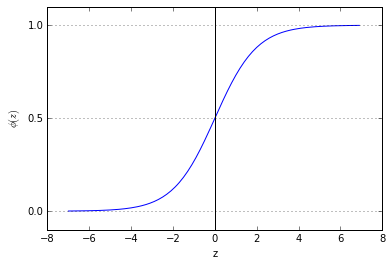

In [1]:
#シグモイド関数のプロット
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#シグモイド関数を定義
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7,7,0.1)
phi_z = sigmoid(z)

plt.plot(z,phi_z)
#垂直線を追加
plt.axvline(0.0,color='k')

plt.ylim(-0.1,1.1)

plt.xlabel('z')
plt.ylabel('$\phi (z)$')
#y軸のメモリを追加
plt.yticks([0.0,0.5,1.0])

#Axesクラスのオブジェクトの取得
ax = plt.gca()
#y軸のメモリに合わせて水平グリッド線を追加
ax.yaxis.grid(True)

plt.show()

# 3.3.2　ロジスティック関数の重みの学習
- ロジスティック回帰における重みの学習は対数尤度を最大化することにより求める。
- 対数尤度が最大になる重みwを求めることになる。
$$L(\vec{w}) = P(\vec{y}|\vec{x};\vec{w}) = \prod^{n}_{i=1}(y^{(i)}|x^{(i)};\vec{w}) = \prod^{n}_{i=1}(\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)}))^{1-y^{(i)}}$$

- 対数関数を適用すると、アンダーフローの可能性が低下する
- 微分が容易になる
$$ l(\vec{w}) = LogL(\vec{w}) = \sum^{n}_{i=1} [y^{(i)}log(\phi(z^{(i)})) + (1-y^{(i)})log(1-\phi(z^{(i)}))]$$

- 勾配降下法を用いて最小化できるコスト関数Jとして対数尤度を書き換える（-1を掛ける）
$$J(\vec{w}) = \sum^{n}_{i=1} [-y^{(i)}log(\phi(z^{(i)})) - (1-y^{(i)})log(1-\phi(z^{(i)}))]$$

# 3.3.3 scikit-learnによるロジスティック回帰モデルのトレーニング

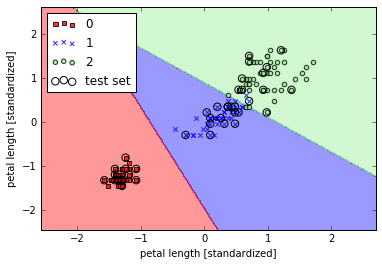

In [9]:
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=1000.0,random_state=0)
# トレーニングデータをモデルに適合させる。
lr.fit(X_train_std,y_train)

#トレーニングデータとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std,X_test_std))
#トレーニングデータとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train,y_test))

#決定領域のプロット
plot_decision_regions(X_combined_std,y_combined,classifier=lr,test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal length [standardized]')

plt.legend(loc='upper left')
plt.show()

# 3.3.4 正則化による過学習への対処
- 過学習は未知のトレーニングデータセットではうまく汎化されないという問題だ。
- 過学習が発生しているモデルは、「バリアンスが高い」と表現される。
- 過学習の要因としては、パラメータの数が多すぎるため、データに対してモデルが複雑すぎることが考えられる。
- これに対して、学習不足は、モデルの複雑さが十分でなはなく、未知のデータに対する性能が低い。
- 学習不足が発生しているモデルは、「バイアスが高い」と表現される。
- バイアスとバリアンスの間にはトレードオフの関係がある。
- トレードオフ関係を探る一つの方法として、正則化に基づいてモデルの複雑さを調整することが挙げられる。
- 正則化は共線性を処理する非常に便利な方法で、データからノイズを取り除き、最終的に過学習を防ぐ
- 正則化の背景にある考え方は、極端なパラメータの重みにペナルティを科すための追加情報を導入するというものである。
- 共線性とは、特徴量の間の相関の高さのことである。
- 最も一般的な正則化は、L2正則化である。$\lambda$が正則化パラメータである。
$$\frac{\lambda}{2}\| \vec{w} \|^{2} = \frac{\lambda}{2} \sum^{m}_{j=1} w^{2}_{j}$$

- 正則化を適用するには、ロジスティック回帰で定義したコスト関数に対して、重みを小さくするための正則化の項を追加する。
- scikit-learnのLogisticRegressionクラスに実装されているCは$\lambda$の逆数である。
- Cの値を小さくすると、正則化の強さを高めることを意味する。
$$J(\vec{w}) = \sum^{n}_{i=1} [-y^{(i)} log(\phi(z^{(i)})) - (1-y^{(i)}) log(1-\phi(z^{(i)}))] + \frac{\lambda}{2} \| \vec{w} \|^{2}$$



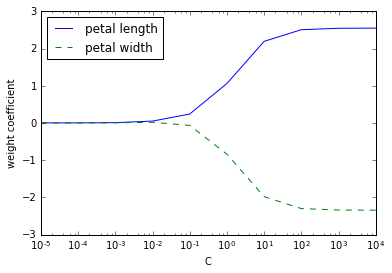

In [17]:
#正則化の強さの可視化、２つの重み係数と逆正則化パラメータの関係をプロット

#空のリストを作成（重み係数、逆正則化パラメータ）
weights, params = [],[]
#10個の逆正則化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10**c,random_state=0)
    lr.fit(X_train_std,y_train)
    #重み係数を格納
    weights.append(lr.coef_[1]) #クラス2とその他のクラスを分類するときに使う重み係数
    #逆正則化パラメータの格納
    params.append(10**c)

#重み係数をNumpy配列に変換
weights = np.array(weights)

#plot
plt.plot(params,weights[:,0],label='petal length')
plt.plot(params,weights[:,1],linestyle='--',label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
#横軸を対数スケール
plt.xscale('log')
plt.show()


- パラメータCが減少する（正則化を強める）と重み係数が0に近づいていく